# Exercise Sheet 8: Optimization for Training Deep Models (Deadline: 06 Jan, 23:59)

For theoretical tasks you are encouraged to write in $\LaTeX$. Jupyter notebooks support them by default. For reference, please have a look at the examples in this short excellent guide: [Typesetting Equations](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Typesetting%20Equations.ipynb)

Alternatively, you can upload the solutions in the written form as images and paste them inside the cells. But if you do this, **make sure** that the images are of high quality, so that we can read them without any problems.

### 0) Preamble : Understanding Gradient Signals of Activation functions (2.5 points)

In Assignment-5, we saw the importance of **activation functions** in action for achieving **non-linear** decision boundary. Because of this functionality/behaviour, these functions are sometimes called simply as **non-linearities** in Deep Learning literature. In this task, we will understand the gradient signals of three different non-linearities: *Sigmoid*, *Tanh*, and *ReLU*. 

(Find more information at: [Comparison_of_activation_functions](https://en.wikipedia.org/wiki/Activation_function#Comparison_of_activation_functions))

In [25]:
import warnings
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

**i**) Implement the activation functions *Sigmoid*, *Tanh*, and *ReLU* and their gradient computation using only basic ops in TensorFlow (**1.5 point**)

(No need to derive the gradient expression, just use it as is (see the link above for help); You can use TensorFlow for stable implementations of $sigmoid$ and $tanh$ calculations. However, you **should do** the gradient computation yourself using *only* the basic ops such as `tf.nn.<activation_function>`, `tf.subtract`, `tf.square` etc.)

Unlike $\color{blue}{NumPy}$, TensorFlow doesn't have support for `float128` as of 2017. So, we will just stick to `tf.float64`.

In [43]:
# can be used to call .eval() on tensors
isess = tf.InteractiveSession()
one = tf.constant(1.0, dtype=tf.float64)
zero = tf.constant(0, dtype=tf.float64)
two = tf.constant(2.0, dtype=tf.float64)
# TODO: implement activation functions & their gradient computations

def sigmoid(x):
    """
    x: numpy array with the range of input values for our plot.
       should be `upcast`ed to float64, before taking sigmoid
    """
    x = tf.cast(x, tf.float64)
    return tf.div (one, (tf.add(one, tf.exp(-x))))


def sigmoid_grad(sigm):
    """
    sigm: compute gradient from the result of sigmoid.
          should be `upcast`ed to float64, before taking sigmoid
    """
    return tf.multiply(sigm, (tf.subtract(one, sigm)))

                       
def relu(x):
    """
    x: numpy array with the range of input values for our plot.
       should be `upcast`ed to float64, before taking relu
    """
    x = tf.cast(x, tf.float64)
    return tf.maximum(zero, x)


def relu_grad(rel):
    """
    rel: numpy array of `relu`ed values for the input
    return a boolean array of dtype `int`
    """
    return (rel >= zero)


def tanh(x):
    """
    x: numpy array with the `range` of input values for our plot.
    should be `upcast`ed to float64, before taking tanh
    """
    
    return tf.subtract(tf.div (two, (tf.add(one, tf.exp( -tf.multiply(two, x))))), one)


def tanh_grad(tnh):
    """
    tnh: numpy array of `tanh`ed values for the input
    """
    return tf.subtract(one, tf.square(tnh))

(ii) Plot the *gradient signals* of `Sigmoid`, `Tanh`, and `ReLU` activation functions overlaid in a single plot. (**0.5 points**) <br>
Use $200$ evenly spaced samples from the closed interval $[-10.0, 11.0]$ as the truncated [domain](https://en.wikipedia.org/wiki/Domain_of_a_function). <br>
$\color{green}{Hint}$: While plotting, set the $y-axis$ limit to $[0, 1.1]$ for better interpretation.

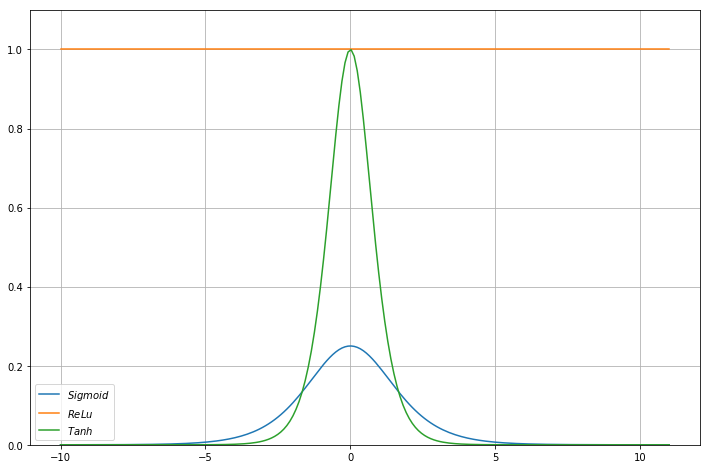

In [45]:
# TODO: implement plotting
samples = np.linspace(-10.0, 11.0, num=200)
init = tf.global_variables_initializer()
plt.ylim(0,1.1)
sig = sigmoid(samples).eval()
sig_der = sigmoid_grad(sig).eval()

rel = relu(samples).eval()
rel_der = relu_grad(rel).eval()

tnh = tanh(samples).eval()
tnh_der = tanh_grad(tnh).eval()

plt.plot(samples, sig_der, label="$Sigmoid$");
plt.plot(samples, rel_der, label="$ReLu$");
plt.plot(samples, tnh_der, label="$Tanh$");

plt.legend()
plt.grid()

**iii**) What do you observe from the plot? (**0.5 points**) <br>
$\color{red}{Note}:$ In addition to your own explanation, your solution should include how the *gradient signal* of one activation function differs from the other, over this truncated domain.

(It is *very important* to understand how these *gradient signals* behave and how one differs from the other. This understanding will be useful for the task below, and also later on when we talk about *RNNs*)

$\color{violet}{Ans}$: 
**Sigmoid Function:** Gradient towards either end of the sigmoid function, the Y values tend to respond very less to changes in X as we can see the gradient at that region is small. That means at that region, the gradient is small or has vanished (cannot make significant change because of the extremely small value). The network refuses to learn further or is drastically slow. It is called “vanishing gradients” problem. 

**Tanh Function:** Gradient is stronger for this function than sigmoid (derivatives are steeper). Hence optimization is easier in this method. But still it suffers from “vanishing gradients” problem.

**ReLu Function:** It avoids and rectifies “vanishing gradients” problem as Relu’s gradient is constant = 1. However for negative X, the gradient can go towards 0 (not visible in the truncated domain). It can cause a weight update which will makes it never activate on any data point again. That means ReLu could result in Dead Neurons.

# 1) Exploding/Vanishing Gradients (7.5 points)

In the lecture we've discussed some of the challenges in Neural Network Optimization. One among them is the so-called **Exploding/[Vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)** .

To be more specific, this problem happens only during the backward pass in training (very deep) Neural Networks.

**i**) Assume that you've a *100-layer* Feed Forward Neural Network with $sigmoid$ activation function as non-linearities. Explain mathematically why the *exploding or vanishing gradient problem* occurs only during the backward pass (and not during the forward pass) (**1 point**) .

$\color{green}{Hint}$: Think about what will happen to the *magnitude of gradient signal* when it reaches the first few layers (*i.e. layers near the input*), during *backpropagation*. The plot you did in *Preamble* section should also give you some intuition.


$\color{violet}{Ans}$:

**ii**) Explain how we can avoid the problem of gradient explosion. Your explanation should talk about what we do with the *norm of the gradient*. (**1 point**) <br>
$\color{green}{Hint}$: You can consult the [DL-book](http://www.deeplearningbook.org/) & TensorFlow API docs for more information; Also, we expect the formula and its explanation in your solution.

$\color{violet}{Ans}$: 

##### iii) Vanishing Gradient Problem in Action (5.5 points)

In this part, you will implement a four layer FFN network in TensorFlow to (visually) understand the vanishing gradient problem.

In [ ]:
# import libraries and data
import warnings
from sklearn.cross_validation import StratifiedShuffleSplit
from tensorflow.examples.tutorials.mnist import input_data

warnings.filterwarnings("ignore")

We'll be using MNIST dataset for this task, but not all 55K samples. Only a subset of 5K samples.

In [ ]:
# read MNIST data
mnist = input_data.read_data_sets("data_MNIST/", one_hot=True)

In [ ]:
# choose a subset of 5K samples (evenly distributed among all classes)

# extract zero-based indices of 1-hot locations in the array.
onehot_indices = [np.where(x==1)[0][0] for x in mnist.train.labels]
sss = StratifiedShuffleSplit(y=onehot_indices, n_iter=1, test_size=5000, random_state=0)

for _, subset_indices in sss:
    subset_images = mnist.train.images[subset_indices]
    subset_labels = mnist.train.labels[subset_indices]

In [ ]:
# training set
train_images = subset_images
train_labels = subset_labels

Implement a *four layer FF Neural Network* in TensorFlow, with first hidden layer size 50, second hidden layer size 50, third hidden layer size 50 (i.e. 50 hidden units), and output layer size corresponding to the size of `num_labels`. Specifically, the network will be: `inputs->hidden1->hidden2->hidden3->output`

$\color{red}{Note}$: $\star$ Initialize the weight matrices using [Xavier initialization](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer). Biases can be initialized with [zeros](https://www.tensorflow.org/api_docs/python/tf/zeros). <br>
$\hspace{2em}$ $\star$ Use `tf.float32` for all tensors, for faster computation. <br>
$\hspace{2em}$ $\star$ Use **sigmoid activation** function as the non-linearity. <br>
$\hspace{2em}$ $\star$ Use $L_2$ regularization (i.e. weight decay) with alpha ($\alpha$) value of *1e-6*. See [tf-api](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss) for more details. <br>
$\hspace{2em}$ $\star$ Use *softmax cross entropy* as the loss function as in Assignment-5. (Note that, generally, this is used only during training time.)<br>
$\hspace{2em}$ $\star$ Use `Gradient Descent Optimizer` with learning rate of 0.5<br>
$\hspace{2em}$ $\star$ Here we are doing *batch training* (i.e. we use all 5K samples at once).<br>

$\color{green}{Hint}$: To understand how the *gradient magnitude (of weights)* changes during training, we need the gradients for the *weights*. Look into [tf-processing-gradients](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#processing_gradients_before_applying_them) for help.

With these in mind, now build the computation graph of our model below. (**1.5 points**)

In [ ]:
# TODO: Implement



# hparams
# ---------
# parameter for regularization.
alpha = 1e-6

# learning rate
lr = 0.5

# TODO: Implement


Implement the function below which computes accuracy. (**0.5 points**)

In [ ]:
# TODO: Implement
def compute_accuracy(predictions, ground_truth):
    """
    compute & return accuracy (in percentage).
    predictions: predictions from the network
    ground_truth: 1-hot array of ground truth labels
    """
                     
    return None

Implement code which performs network training (with `num_steps = 3001`). (**1.5 point**) <br>
$\color{green}{Hint}$: To understand how the *gradient magnitude (of weights)* (i.e. their absolute values) changes across layers and with each of the 3K steps, we need to cache the *mean of absolute value of gradients (of weights)* of all 4 layers in each step of the total 3K steps. We'll need these gradients for plotting later on.

In [ ]:
# TODO: implement network training
# 
# TODO: cache the mean of absolute value of gradients
#
# TODO: print stats for every 100 steps


Train the network for 3K steps. Print the *loss* and *training accuracy* after every 100 steps. <br> (This will be helpful as a sanity check for your implementation and also for the later analysis question) <br>
$\color{green}{Hint}$: If you implement it correctly, and train it for 3K steps with the provided hyperparameters, the execution time on a 4GB machine would be *ca. 12 mins*, and the *training accuracy* would be around 99.9%. Also, here we're doing only training; i.e. no validation and testing.

**iv**) **Plotting**

Now, plot the value of gradient magnitudes of all 4 layers, overlaid in a single plot. (**1 point**) <br>
$\color{green}{Hint}$: Your $x-axis$ should be $\#steps$ and $y-axis$ should have the *mean value of gradient magnitudes (of weights)* corresponding to all 4 layers.

$\color{red}{Note}$: The important part of this exercise is the plot that explains the *vanishing gradient problem* and the observations that you make out of it.

In [ ]:
# TODO: implement plotting
#
# 

Q1) What are your observations from the above plot? How does the *flow of gradient signal* through different layers changes with the increase in number of steps (during training)? (**0.5 points**)

$\color{violet}{Ans}$:

Q2) Now, analyze the *training accuracy & loss values* from the stats of the whole training loop. At the same time (in parallel), observe from the plot how the gradient signal(magnitude) changes across layers as the steps increase. *Relate these two observations* and explain your findings. (**0.5 points**) <br>

$\color{violet}{Ans}$:

# 2) Understanding Optimization Algorithms (10 points)

### Optimization algorithms for Deep Neural Networks

In this task, you will study and understand various optimization methods such as *Vanilla Gradient Descent, Gradient Descent with Momentum, AdaGrad, Adam, and RMSProp*. <br>
For a terse & high level overview of these algorithms, see here: [SGD-variants](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Extensions_and_variants)

$\color{red}{Note}$: Adam was *not introduced* in the lecture but it's an important algorithm to know, particularly for NLP & Computer Vision problems. Refer [section 8.5.3](http://www.deeplearningbook.org/contents/optimization.html) for details. <br>

#### 1) Stochastic Gradient Descent (SGD) Optimizer (2 points)

i) Is it important to use *learning rate decay* for (mini-batch) SGD based learning? Justify. (**0.5 + 1 points**) <br>
ii) What is the advantage of using a *small batch size* during training instead of the *full set of examples at once* in the training data? (**0.5 points**)

$\color{violet}{Ans}$:

i) <br>
ii) 

#### 2) Momentum Optimizer (2 points)

Familiarize yourself with the algorithm from the lecture slide and [DL book](http://www.deeplearningbook.org/contents/optimization.html) and understand how it works.<br>
i) Now describe, in what way Momentum method is different from *vanilla SGD*? (**1 point**)

ii) It is known that the cost function of NNs usually has many saddle points. How does momentum method help to alleviate the problem of getting stuck in these saddle points when compared to vanilla SGD? (**1 point**) <br>
$\color{red}{Note}$: You can assume that, in both cases, we start at the same initial point.

$\color{violet}{Ans}$:

i) <br>
ii) 

#### 3) AdaGrad optimizer (2 points)

Further reading: [Adaptive SubGradient Methods for Stochastic Optimization](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

$\color{red}{Note}$: An important algorithm for NN training for NLP and CV problems.

Refer the slides and the [DL book](http://www.deeplearningbook.org/contents/optimization.html) and understand how AdaGrad algorithm works.  <br>
i) Describe the basic idea behind AdaGrad algorithm. (**1 point**) <br>
ii) What is the disadvantage of this algorithm, in practice? (**0.5 points**)<br>
iii) What is the important property of this algorithm? (**0.5 points**)

$\color{violet}{Ans}$:  <br>
i)  <br>
ii) <br>
iii) <br>

##### 4) RMSProp optimizer (2 points)

i) How does RMSProp differ from AdaGrad?  (**1 point**) <br>
ii) What disadvantage(s) in AdaGrad are solved by RMSProp? Explain it using the formula. (**1 point**)

$\color{violet}{Ans}$:  <br>
i)  <br>
ii) <br>

#### 5) Adam Optimizer (2 points)

Further reading: [ADAM: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980.pdf)

$\color{red}{Note}$: Adam was *not introduced* in the lecture but it's an important algorithm to know, particularly for NLP & Computer Vision problems. Refer [section 8.5.3](http://www.deeplearningbook.org/contents/optimization.html) for details. <br>

i) Is there any similarity between RMSProp and Momentum? Is it possible to combine them? (**1 point**)

ii) Describe the way in which Adam algorithm performs parameter update.<br>
What are the advantage(s) of such an update rule when compared to RMSProp (with momentum)? (**1 point**)

$\color{violet}{Ans}$:  <br>
i)  <br>
ii) <br>

# Christmas Bonus (1 point)

Where and how could you apply a deep neural network for ensuring safety of humans during Christmas & New Year celebrations?

-----------------------------------------------------------------------------------------------

# $\color{red}{\star \star We\hspace{0.5em}Wish\hspace{0.5em}You\hspace{0.5em}a\hspace{0.5em}Merry\hspace{0.5em}Christmas! \star \star} $ $\color{violet}{\&}$ $\color{green}{Happy\hspace{0.5em}New\hspace{0.5em}Year!} $ - NNIA Team

--------------------------------------------------------------------------

## Submission instructions
You should provide a single Jupyter notebook as the solution. The naming should include the assignment number and matriculation IDs of all members in your team in the following format:
**assignment-8_matriculation1_matriculation2_matriculation3.ipynb** (in case of 3 members in a team). 
Make sure to keep the order matriculation1_matriculation2_matriculation3 the same for all assignments.

Please submit the solution to your tutor (with **[NNIA][assignment-8]** in email subject):
1. Maksym Andriushchenko <s8mmandr@stud.uni-saarland.de>
2. Marius Mosbach <s9msmosb@stud.uni-saarland.de>
3. Marimuthu Kalimuthu <s8makali@stud.uni-saarland.de>
4. Rajarshi Biswas <rbisw17@gmail.com>

Note :  **If you are in a team, you should submit only 1 solution to only 1 tutor.** <br>
$\hspace{2em}$ **Submissions violating these rules will not be graded.**